<div style="text-align:center"><a href="https://colab.research.google.com/github/PexMor/jupyter-playground/blob/main/regression-in-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/>
<a style="display:inline-block" href="https://github.com/PexMor/jupyter-playground/blob/main/regression-in-pytorch.ipynb" target="_parent"><img alt="GitHub forks" src="https://img.shields.io/github/forks/PexMor/jupyter-playground?label=fork%20me&logo=github&style=plastic"></a></div>

# Regression in PyTorch

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [1]:
!pip -q install watermark tabulate torch ipywidgets numpy seaborn

In [2]:
import watermark
%load_ext watermark
%gui asyncio

In [3]:
import threading
from IPython import display
import ipywidgets as widgets
import time
import tabulate
import datetime
import math
import seaborn
# original import moved to be captured by watermark
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%watermark -i -n -v -m -iv

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : Clang 12.0.5 (clang-1205.0.22.9)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

numpy     : 1.21.2
watermark : 2.2.0
torch     : 1.9.0
tabulate  : 0.8.9
IPython   : 7.25.0
ipywidgets: 7.6.3
seaborn   : 0.11.2
matplotlib: 3.4.2



In [5]:
class TabOut:
    def __init__(self, headers, show_rel_ts = True, show_abs_ts = True, tail_len = 10, display_interval = 2):
        self.headers = headers
        self.show_rel_ts = show_rel_ts
        self.show_abs_ts = show_abs_ts
        self.tail_len = tail_len
        self.display_interval = display_interval
        if self.show_rel_ts:
            self.headers.append("Rel.time[s]")
        if self.show_abs_ts:
            self.headers.append("Abs.time[s]")
        self.data = []
        self.last_show_ts = self.last_ts = self.base_ts = datetime.datetime.now()
        
    def display(self, row, text = "In Progress!", progress = -1.0):
        loc_row = row.copy()
        now_ts = datetime.datetime.now()
        dur_rel = (now_ts - self.last_ts).total_seconds()
        dur_abs = (now_ts - self.base_ts).total_seconds()
        self.last_ts = now_ts
        if self.show_rel_ts:
            loc_row.append(dur_rel)
        if self.show_abs_ts:
            loc_row.append(dur_abs)
        self.data.append(loc_row)
        delta_show = (now_ts - self.last_show_ts).total_seconds()
        if delta_show > self.display_interval:
            self.last_show_ts = now_ts
            self.show(text,progress)
        
    def get_data(self):
        return self.data
    
    def clear(self):
        self.data = []
        
    def show(self, text, progress = -1.0):
        display.clear_output(wait=False)
        html = f"<h2>{text}</h2>"
        if self.tail_len > 0:
            html += tabulate.tabulate(self.data[-self.tail_len:], tablefmt='html',headers=self.headers)
        else:
            html += tabulate.tabulate(self.data[-self.tail_len:], tablefmt='html',headers=self.headers)
        html += f"<h2>{text}</h2>"
        display.display(display.HTML(html))

    def done(self, text = "Done!", show_all = False):
        if show_all:
            self.tail_len = -1
        self.show(text)

In [6]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # E.g.: Dosage of drug for treating Alzheimer's disease
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [7]:
# y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)

For reproducibility of this demo, here's a fixed example of $y$ values obtained by running the commented-out line above: 

In [8]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

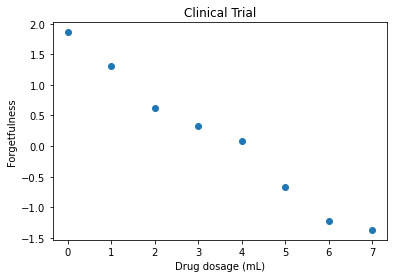

In [9]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

(**N.B.**: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [10]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$: 

In [11]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [12]:
def regression(my_x, my_m, my_b):
    return my_m * my_x + my_b

In [13]:
def regression_plot(my_x, my_y, my_m, my_b):
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b)
    y_max = regression(x_max, my_m, my_b)

    ax.set_xlim([x_min, x_max])
    ax.plot([x_min, x_max], [float(y_min), float(y_max)])

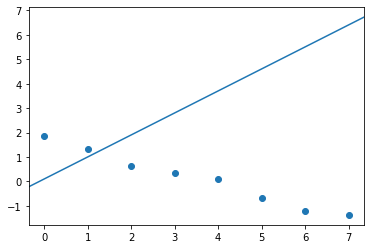

In [14]:
regression_plot(x, y, m, b)

**Return to slides here if following *Calculus I* class.**

### Machine Learning
In four easy steps :)

**Step 1**: Forward pass

In [15]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [16]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [17]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [18]:
C.backward()

In [19]:
m.grad

tensor([36.3050])

In [20]:
b.grad

tensor([6.2650])

**Step 4**: Gradient descent

In [21]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [22]:
optimizer.step()

Confirm parameters have been adjusted sensibly: 

In [23]:
m

tensor([0.5369], requires_grad=True)

In [24]:
b

tensor([0.0374], requires_grad=True)

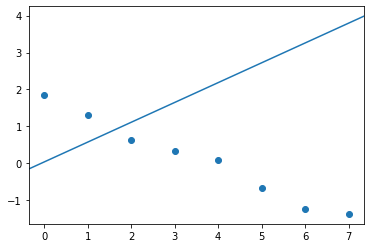

In [25]:
regression_plot(x, y, m, b)

We can repeat steps 1 and 2 to confirm cost has decreased: 

In [26]:
C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost toward zero: 

In [27]:
epochs = 1000
out = TabOut(headers=["Epoch","cost", "m.grad", "b.grad", "m", "b"])
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2
    
    C.backward() # Step 3
    optimizer.step() # Step 4
    
    tab = [epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item(), '%.3g' % m.item(), '%.3g' % b.item()]
    out.display(tab,progress = epoch/epochs)
    # print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))
out.done(show_all=False)

Epoch,cost,m.grad,b.grad,m,b,Rel.time[s],Abs.time[s]
990,0.0195,0.000709,-0.00348,-0.468,1.75,0.000154,0.173575
991,0.0195,0.000704,-0.00346,-0.468,1.75,0.00016,0.173735
992,0.0195,0.000701,-0.00344,-0.468,1.75,0.000154,0.173889
993,0.0195,0.000697,-0.00342,-0.468,1.75,0.000153,0.174042
994,0.0195,0.000692,-0.0034,-0.468,1.75,0.000153,0.174195
995,0.0195,0.000689,-0.00338,-0.468,1.75,0.000158,0.174353
996,0.0195,0.000685,-0.00337,-0.468,1.75,0.000156,0.174509
997,0.0195,0.00068,-0.00335,-0.468,1.75,0.000155,0.174664
998,0.0195,0.000677,-0.00333,-0.468,1.75,0.000154,0.174818
999,0.0195,0.000673,-0.00331,-0.468,1.75,0.000155,0.174973


In [28]:
def work(progress):
    total = 100
    for i in range(total):
        time.sleep(0.1)
        progress.value = float(i+1)/total

def test_progress_bar():
    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    thread = threading.Thread(target=work, args=(progress,))
    display.display(progress)
    thread.start()

# if the background process would be slow then bakground thread might get useful
# commented out not to slow down the execution
# test_progress_bar()

In [29]:
# we have the data trace in string form
# out.get_data()

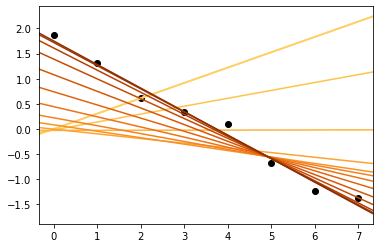

In [30]:
trace = out.get_data()
no_lines = 20
scale = 2.5

# https://seaborn.pydata.org/tutorial/color_palettes.html
# palette = "light:#ECC"
# palette = "rocket_r"
# palette = "Blues"
palette = "YlOrBr"
with seaborn.color_palette(palette, n_colors=no_lines):
    fig, ax = plt.subplots()
    # plot the source data
    ax.scatter(x, y, color='#000000')
    # get the x limits
    x_min, x_max = ax.get_xlim()
    ax.set_xlim([x_min, x_max])

    def plot(no):
        my_m = float(trace[no][4])
        my_b = float(trace[no][5])
        y_min = x_min * my_m + my_b
        y_max = x_max * my_m + my_b
        ax.plot([x_min, x_max], [float(y_min), float(y_max)])

    samples = [ 0 ]
    cnt = 2
    no = 1.1
    while cnt < no_lines:
        samples.append(no)
        no = cnt**7
        cnt += 1
    max_no = samples[-1]
    
    # normalize the samples no to its scale
    for ii in range(len(samples)):
        frag = (samples[ii] / max_no)
        samples[ii] = math.floor((len(trace)-1) * frag)
    
    # plot the samples
    for no in samples:
        plot(no)

The progress can also be followed interactively via ipywidget.

You can use your mouse or left/down and right/up arrows (eventually PgUp/PgDn for larger steps).

This is good for epoch by epoch stepping during initial rapid period.

In [31]:
def f(epoch):
    global v_epoch
    v_epoch = epoch
    plt.figure(2)
    plt.ylim([-1.5, 2.5])
    plt.scatter(x, y, color='#000000')
    x_min, x_max = plt.xlim()
    plt.xlim([x_min, x_max])
    my_m = float(trace[epoch][4])
    my_b = float(trace[epoch][5])
    y_min = x_min * my_m + my_b
    y_max = x_max * my_m + my_b
    plt.text(x_min + 0.05,-0.95,f"${my_m:.3g} = m,slope$\n${my_b:.3g} = b,intercept$",{"ha":"left","va":"top"})
    plt.plot([x_min, x_max], [float(y_min), float(y_max)],color='#CC9999')
    plt.show()

# the continuous_update is turned to prevent visual lag, so you have to release mouse on slider to refresh
interactive_plot = widgets.interactive(f, epoch=widgets.IntSlider(min=0,max=len(trace)-1,continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='epoch', max=999), Output(layout…

And the final plot alone.

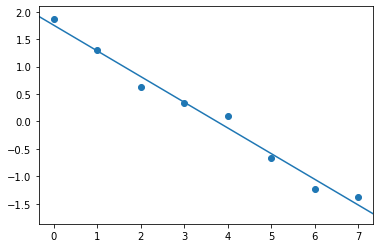

In [32]:
regression_plot(x, y, m, b)

In [33]:
m.item()

-0.4681258499622345

In [34]:
b.item()

1.7542961835861206

**N.B.**: The model doesn't perfectly approximate the slope (-0.5) and $y$-intercept (2.0) used to simulate the outcomes $y$ at the top of this notebook. This reflects the imperfectness of the sample of eight data points due to adding random noise during the simulation step. In the real world, the best solution would be to sample additional data points: The more data we sample, the more accurate our estimates of the true underlying parameters will be. 